In [1]:
import geopandas as gpd
import momepy as mm
import osmnx as ox
import numpy as np
from shapely.geometry import box
import utils

In [2]:
buildings = gpd.read_file('../../nairobi/nairobi_entire_rec.shp')

In [3]:
boundary = gpd.GeoSeries([box(*buildings.total_bounds).buffer(200)], crs=buildings.crs).to_crs(4326).iloc[0]

In [4]:
G = ox.graph_from_polygon(boundary, network_type='all')
edges = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True).to_crs(buildings.crs)

In [5]:
edges = mm.remove_false_nodes(edges.explode().reset_index(drop=True))

In [6]:
edges = edges[['highway', 'geometry']]
edges['highway'] = edges['highway'].astype(str)

In [7]:
edges.to_parquet('../../nairobi/edges.pq')

<ipython-input-7-d0e3c8da095e>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  edges.to_parquet('../../nairobi/edges.pq')


## Preprocess buildings

In [ ]:
buildings.geometry = buildings.buffer(0)

In [9]:
buildings = buildings[~buildings.geometry.isna()]

In [10]:
buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)

In [11]:
buildings.geom_type.value_counts()

Polygon    623986
dtype: int64

In [12]:
buildings = buildings[buildings.area > 10]

In [13]:
buildings = gpd.GeoDataFrame(geometry=utils.fill_insides(buildings))
buildings["uID"] = range(len(buildings))
buildings.crs

<Projected CRS: EPSG:32737>
Name: WGS 84 / UTM zone 37S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - S hemisphere - 36°E to 42°E - by country
- bounds: (36.0, -80.0, 42.0, 0.0)
Coordinate Operation:
- name: UTM zone 37S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
buildings.to_parquet('../../nairobi/buildings.pq')

<ipython-input-14-ad0fc5aa7953>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet('../../nairobi/buildings.pq')


## Generate tessellation

In [15]:
check = mm.CheckTessellationInput(buildings)

Collapsed features  : 10
Split features      : 1073
Overlapping features: 14


In [18]:
buildings = buildings.drop(check.collapse.index.union(check.overlap.index).union(check.split.index))

In [ ]:
limit = mm.buffered_limit(buildings, 100)
%time tess = mm.Tessellation(buildings, "uID", limit, segment=2).tessellation

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [ ]:
tess.to_parquet('../../nairobi/tessellation.pq')

In [25]:
tess.shape

(506435, 2)

In [2]:
buildings = gpd.read_parquet('../../nairobi/buildings.pq')
edges = gpd.read_parquet('../../nairobi/edges.pq')
tess = gpd.read_parquet('../../nairobi/tessellation.pq')

## Generate blocks

In [4]:
%time blocks, b_id, t_id = utils._pysal_blocks(tess, edges, buildings, id_name='bID', unique_id='uID')
buildings['bID'] = b_id
tess['bID'] = t_id

In [5]:
blocks.to_parquet('../../nairobi/blocks.pq')

<ipython-input-5-9b1c531f2f26>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  blocks.to_parquet('../../nairobi/blocks.pq')


## Link streets

In [7]:
edges["nID"] = range(len(edges))
buildings['nID'] = mm.get_network_id(buildings, edges, 'nID', min_size=500)  
tess = tess.merge(buildings[['uID', 'nID']], on='uID', how='left')

Generating centroids...


Snapping:   0%|          | 17/507532 [00:00<51:48, 163.26it/s]

Generating rtree...


Snapping: 100%|██████████| 507532/507532 [1:01:50<00:00, 136.78it/s]
/opt/conda/lib/python3.8/site-packages/momepy/elements.py:810: UserWarning: Some objects were not attached to the network. Set larger min_size. 376 affected elements
  warnings.warn(


In [8]:
tess.to_parquet('../../nairobi/tessellation.pq')
buildings.to_parquet('../../nairobi/buildings.pq')
edges.to_parquet('../../nairobi/edges.pq')

<ipython-input-8-c7452f6c82a7>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tess.to_parquet('../../nairobi/tessellation.pq')
<ipython-input-8-c7452f6c82a7>:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production sett

<AxesSubplot:>

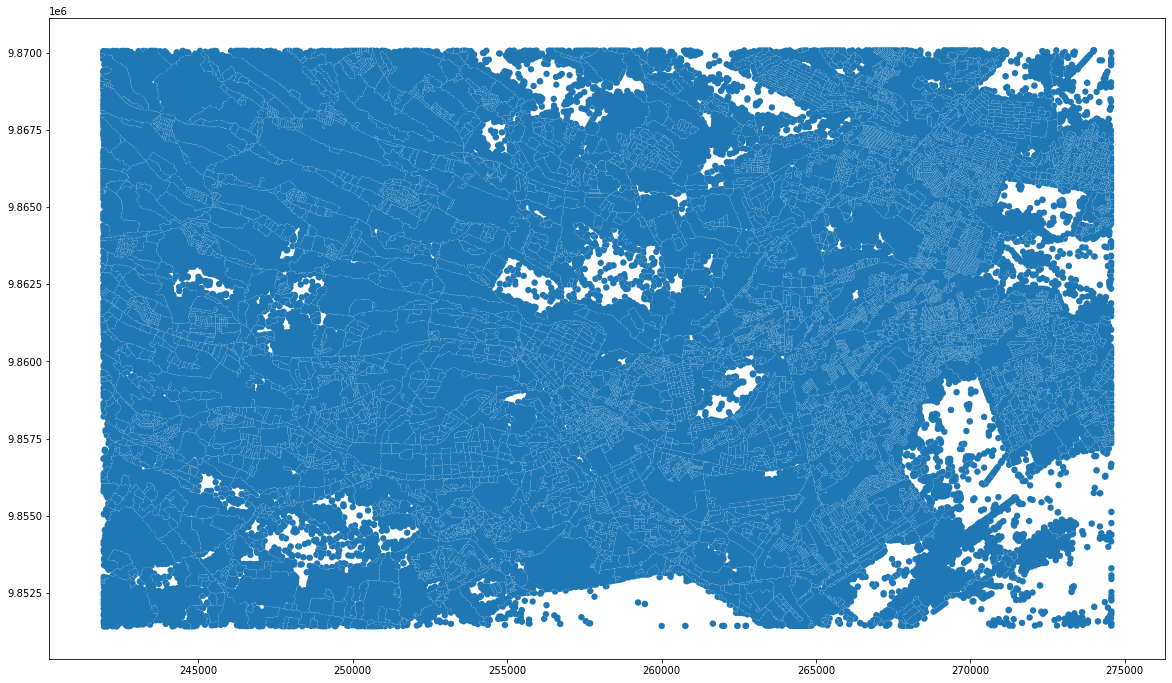

In [9]:
blocks.plot(figsize=(20,20))

<AxesSubplot:>

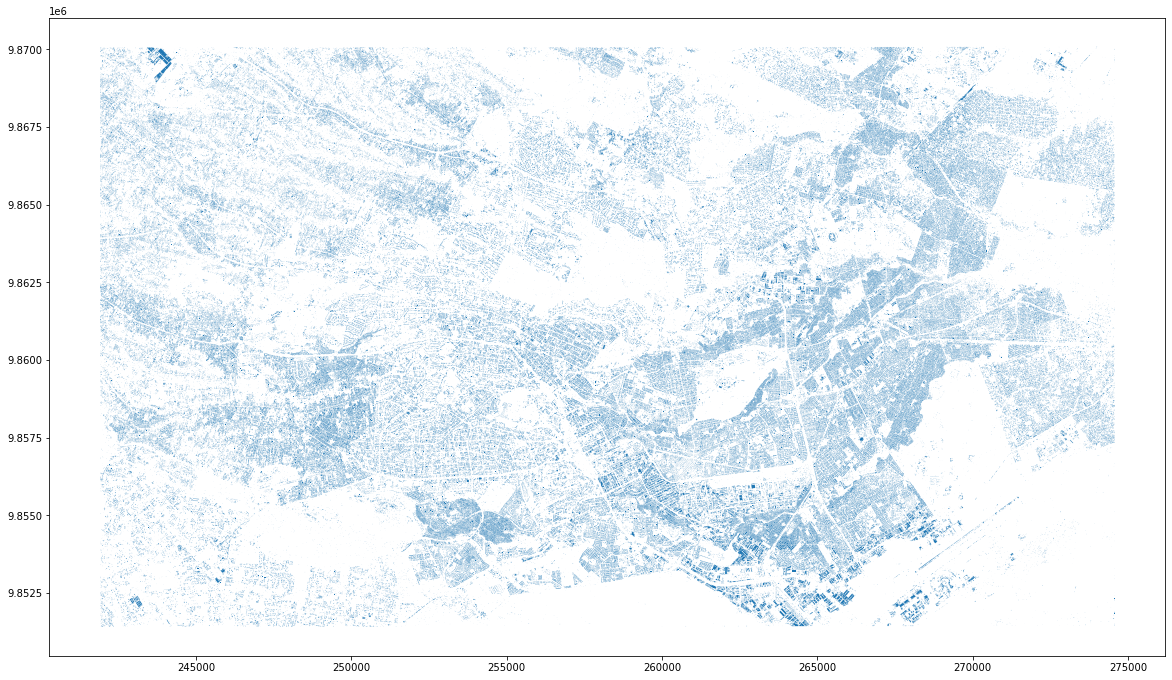

In [10]:
buildings.plot(figsize=(20,20))

<AxesSubplot:>

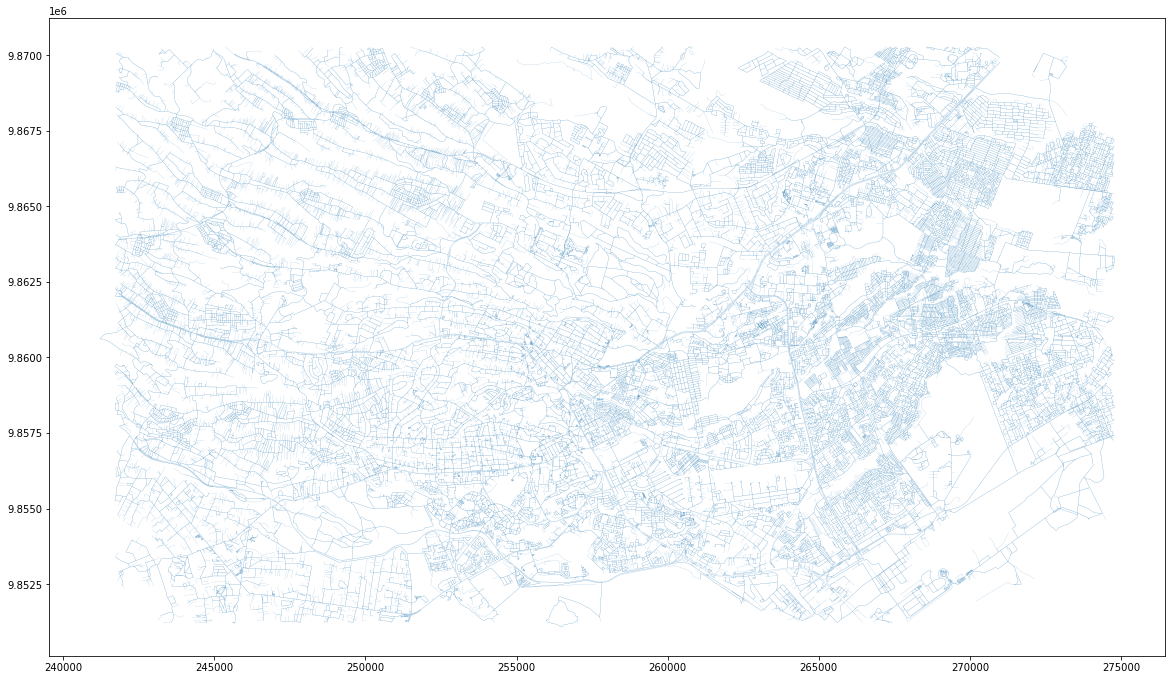

In [12]:
edges.plot(figsize=(20,20), linewidth=.1)